In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

#import string

In [335]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [336]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
print(df.shape)
df.isna().sum().sort_values(ascending=False)

(11162, 17)


balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

In [337]:
df.iloc[2000:2010]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
2000,26,services,married,secondary,no,"77,00 $",yes,no,cellular,15,may,619,1,340,4,failure,yes
2001,35,blue-collar,married,primary,no,"22,00 $",yes,no,cellular,15,may,1190,2,302,2,other,yes
2002,22,blue-collar,single,secondary,no,"-51,00 $",yes,no,cellular,15,may,859,1,-1,0,unknown,yes
2003,26,blue-collar,single,secondary,no,"26,00 $",yes,yes,cellular,15,may,899,1,-1,0,unknown,yes
2004,28,admin.,single,secondary,no,"154,00 $",yes,no,cellular,15,may,536,1,364,1,other,yes
2005,35,admin.,divorced,secondary,no,"534,00 $",no,no,cellular,15,may,669,1,312,3,failure,yes
2006,35,housemaid,married,tertiary,no,"1 265,00 $",yes,no,cellular,15,may,326,5,179,4,failure,yes
2007,55,technician,married,tertiary,no,"-466,00 $",yes,no,cellular,15,may,901,1,-1,0,unknown,yes
2008,32,services,married,secondary,no,"38,00 $",yes,no,cellular,15,may,744,1,-1,0,unknown,yes
2009,28,management,single,secondary,no,"703,00 $",yes,no,cellular,15,may,485,1,88,1,other,yes


In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [339]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [340]:
df['balance'] = df['balance'].apply(lambda x: str(x).replace(' ','').replace('$', '').replace(',', '.')).astype(np.float64)
df['balance'] = df['balance'].fillna(df['balance'].median())

df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)

In [341]:
pop_edu = df['education'].value_counts(ascending=False).reset_index()['education'][0]
pop_job = df['job'].value_counts(ascending=False).reset_index()['job'][0]

df[(df['education']==pop_edu) & (df['job']==pop_job)]['balance'].mean().round(3)

1598.883

In [342]:
# удалите все выбросы для признака balance
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    """The function is designed to define outliers in a data set according to 
    the Tjuki method

    Args:
        data (dataframe): source DF
        feature (str): feature to evaluate
        left (float, optional): left limit. Defaults to 1.5.
        right (float, optional): right limit. Defaults to 1.5.
        log_scale (bool, optional): if data should be treated logarithmically. 
            Defaults to False.

    Returns:
        df,df,float,float: outliers, cleaned, lower_bound, upper_bound
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, low, high = outliers_iqr_mod(df, 'balance', log_scale=False)
print(f'Outliers according the Tjuki method: {outliers.shape[0]}')
dfc = cleaned
print(f'DF shape with outliers removed: {dfc.shape}')
print(f"low bound: {round(low,0)} | high bound: {round(high,0)}")

Outliers according the Tjuki method: 1057
DF shape with outliers removed: (10105, 17)
low bound: -2241.0 | high bound: 4063.0


,deposit,count
0,no,5424
1,yes,4681


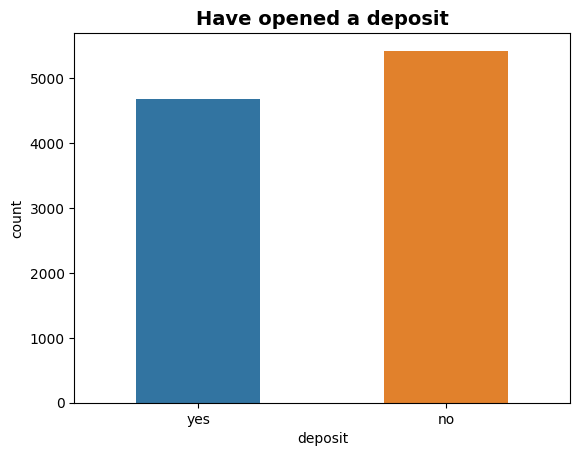

In [343]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(dfc['deposit'].value_counts(normalize=False).reset_index().round(2))

cp = sns.countplot(dfc, x='deposit', width=0.5);
cp.set_title('Have opened a deposit', fontsize=14, fontweight='bold');

In [344]:
dfc.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


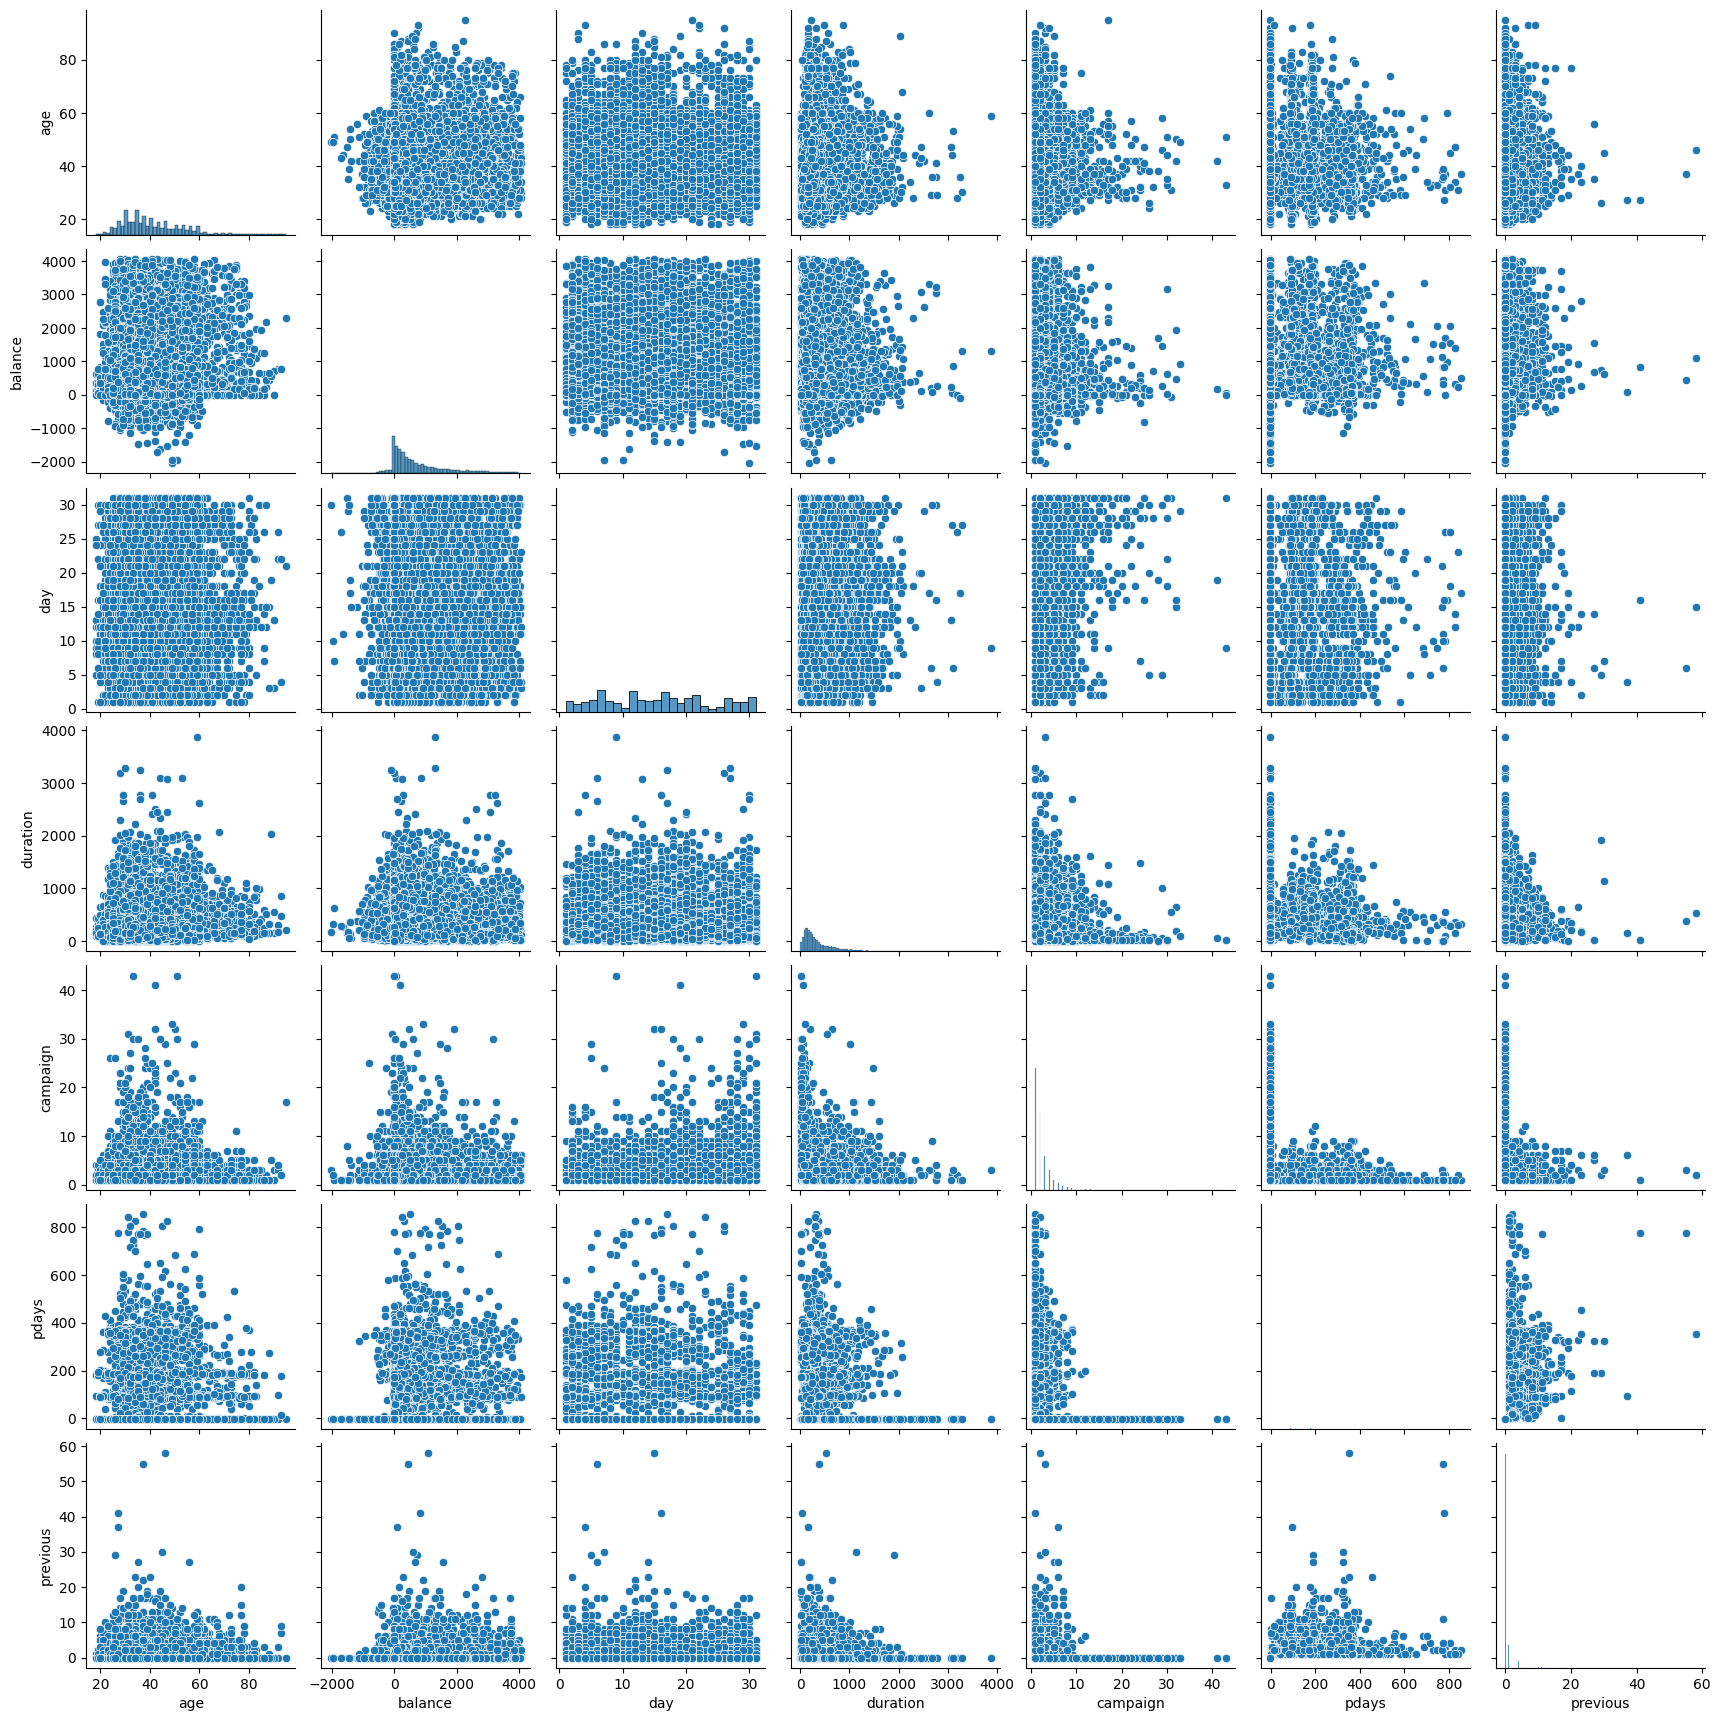

In [345]:
num_fea = dfc.dtypes[dfc.dtypes != 'object'].index.tolist()
sns.pairplot(dfc[num_fea]);

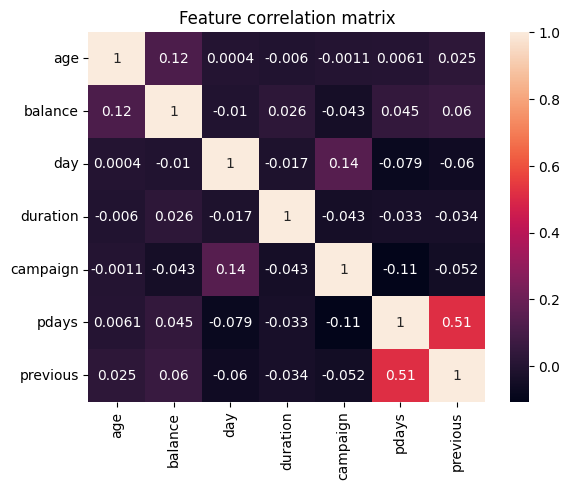

In [346]:
sns.heatmap(dfc.corr(numeric_only=True), annot=True).set_title('Feature correlation matrix');

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


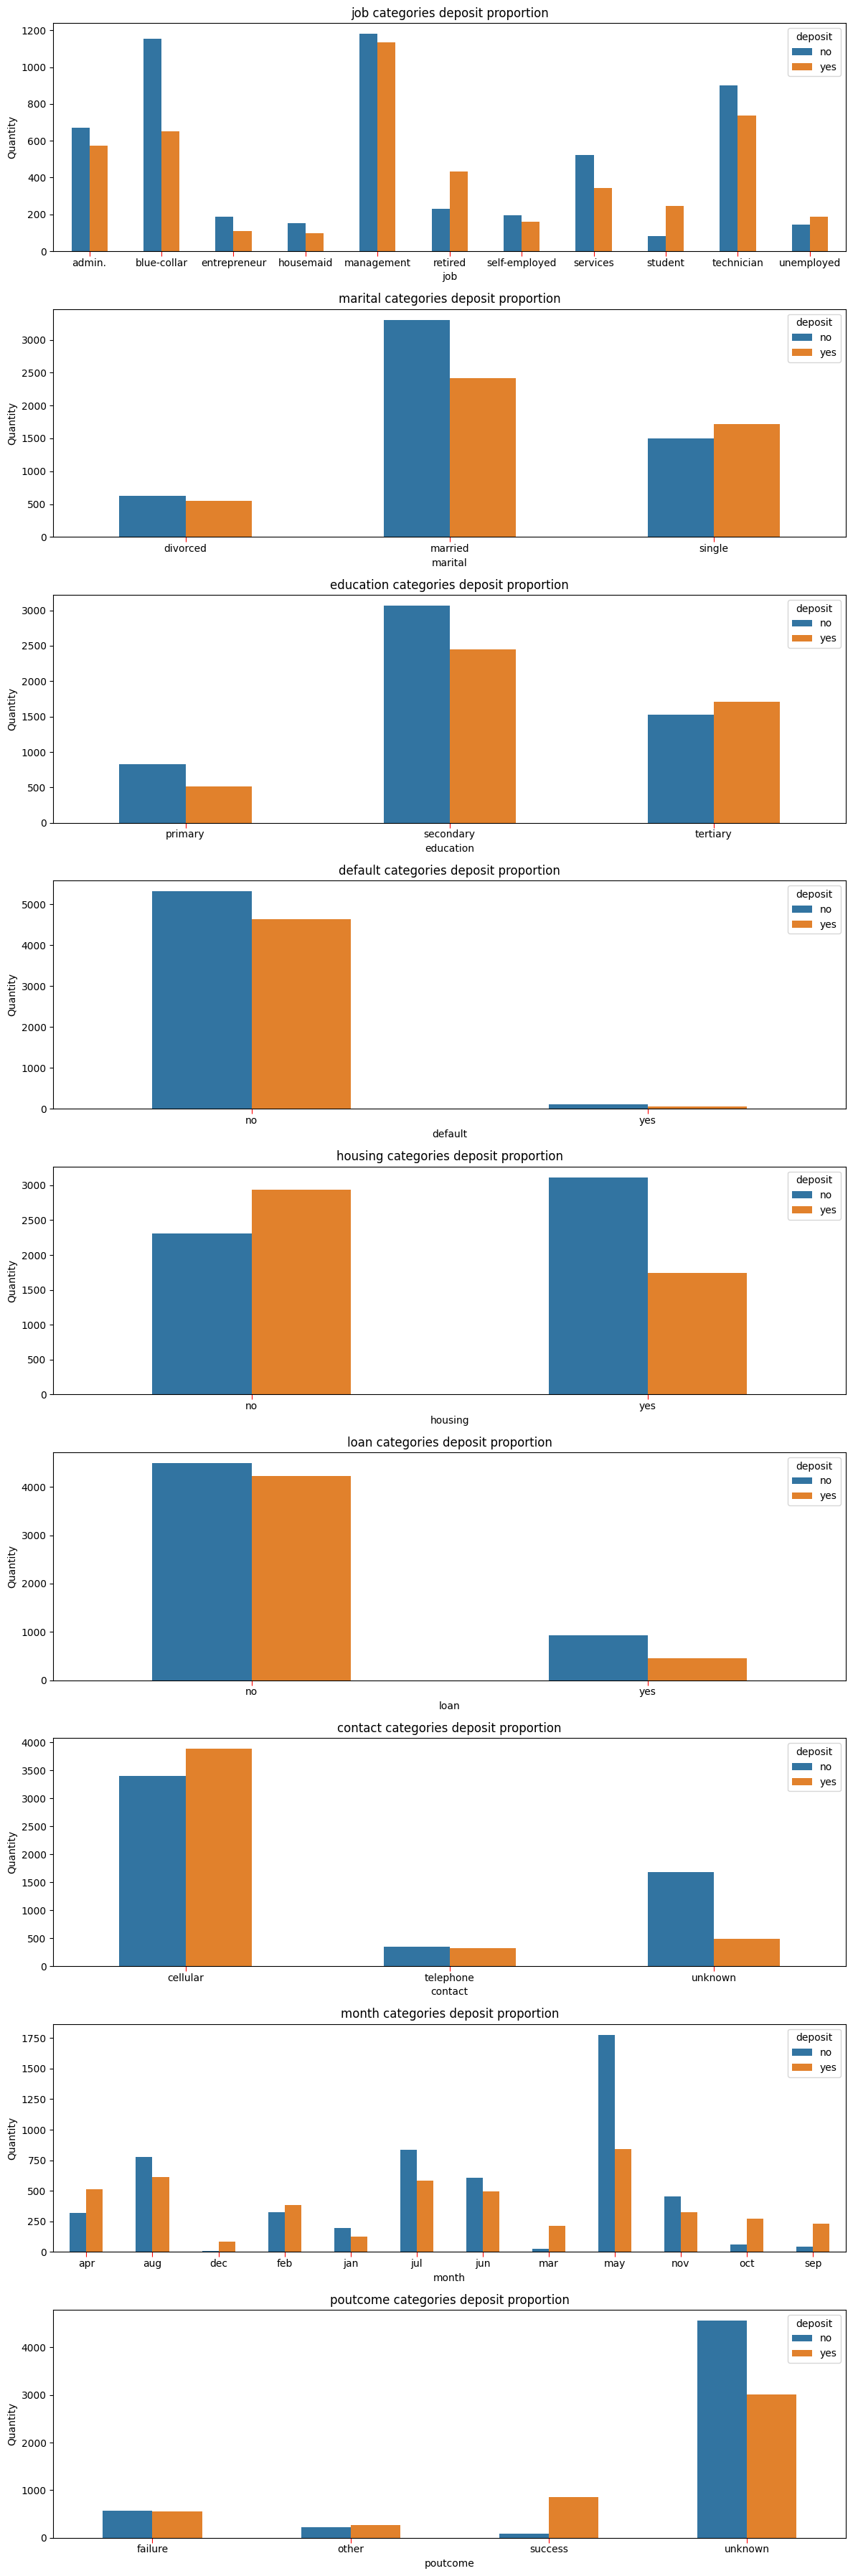

In [347]:
cat_fea = dfc.dtypes[dfc.dtypes == 'object'].index.tolist()
display(dfc[cat_fea].describe())
cat_fea.remove('deposit')

f,a = plt.subplots(nrows=len(cat_fea), ncols=1, figsize=(12,36))
for k, m in enumerate(cat_fea):
    dfg = dfc.groupby([m, 'deposit'])['deposit'].count().rename('qty').reset_index()
    bp = sns.barplot(dfg, x=m, y='qty', hue='deposit', ax=a[k], width=0.5)
    bp.set(xlabel=m, ylabel='Quantity', title=f"{m} categories deposit proportion")
    bp.tick_params(axis='x',rotation=0, direction='out', pad=2, length=5, grid_alpha=0.3, which='both', color='red')
plt.tight_layout()

In [348]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
dc = dfc.groupby(['poutcome', 'deposit'])['deposit'].count().unstack()
dc

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


,month,deposit,proportion
16,may,no,0.678640
8,jan,no,0.608150
10,jul,no,0.589563
18,nov,no,0.584615
2,aug,no,0.559567
12,jun,no,0.548913
7,feb,no,0.455571
1,apr,no,0.381928
21,oct,no,0.185075
23,sep,no,0.165468


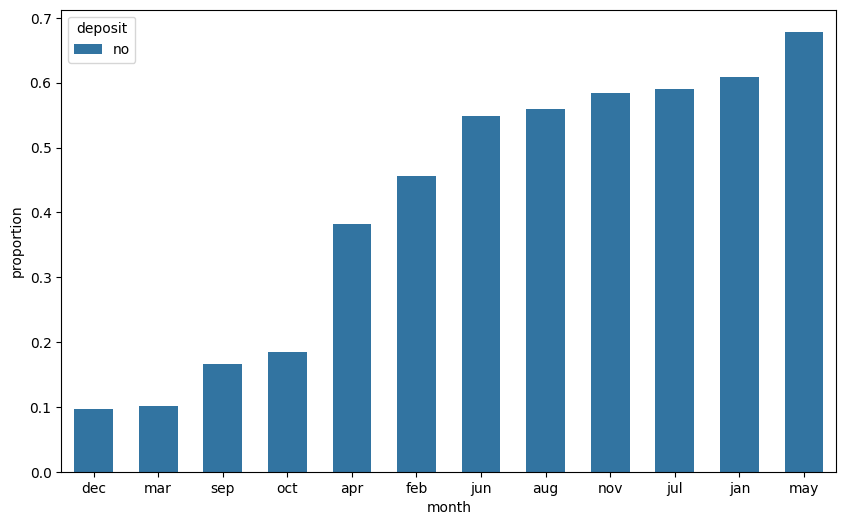

In [349]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df_7 = dfc.groupby(['month'])['deposit'].value_counts(normalize=True).reset_index().sort_values(by=('proportion'))
plt.subplots(figsize=(10,6))
bp_7 = sns.barplot(df_7[df_7['deposit']=='no'], x='month', y='proportion', hue='deposit', width=0.6)
df_7[df_7['deposit']=='no'].sort_values(by='proportion', ascending=False)


,age_group,deposit,proportion
0,30-40,no,0.576523
1,30-40,yes,0.423477
2,40-50,no,0.603104
3,40-50,yes,0.396896
4,50-60,no,0.574154
5,50-60,yes,0.425846
6,<30,yes,0.562032
7,<30,no,0.437968
8,>60,yes,0.810916
9,>60,no,0.189084


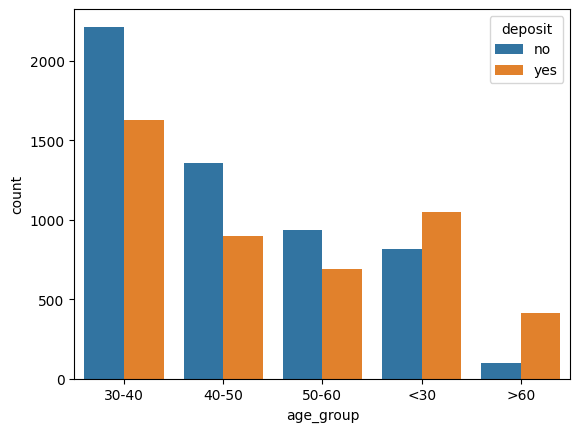

In [350]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
#df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

def group_age(num):
    if num <=30:
        return '<30'
    elif num>30 and num<=40:
        return '30-40'
    elif num>40 and num<=50:
        return '40-50'
    elif num>50 and num<=60:
        return '50-60'
    else:
        return '>60'
    
dfc['age_group'] = dfc['age'].apply(group_age)
display(dfc.groupby('age_group')['deposit'].value_counts(normalize=True).reset_index())

sns.countplot(dfc.sort_values(by='age_group'), x='age_group', hue='deposit').set_title('');

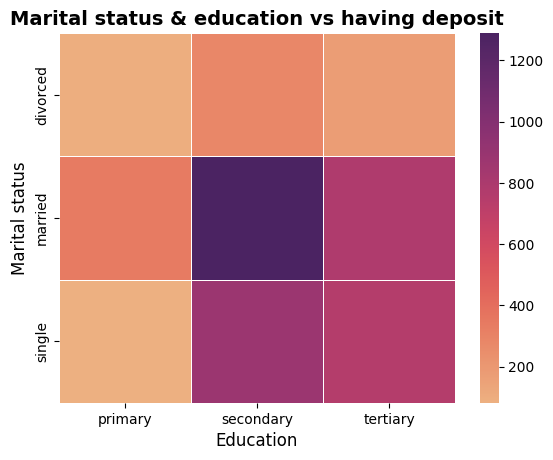

In [351]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pivot = pd.pivot_table(
    dfc[dfc['deposit']=='yes'],
    values= 'deposit',
    index= 'marital',
    columns='education',
    aggfunc='count'    
)

hm = sns.heatmap(pivot,annot=False, linewidths=.5, cmap='flare')
hm.set_title('Marital status & education vs having deposit', fontsize=14, fontweight='bold')
hm.set_ylabel('Marital status', fontsize=12)
hm.set_xlabel('Education', fontsize=12);

In [352]:
# преобразуйте уровни образования
#ct = ColumnTransformer(transformers=[
#    ('label_enc', OrdinalEncoder(), ['education','age_group'])
#], remainder='passthrough')

oe = OrdinalEncoder()
dfc.loc[:, ['education', 'age_group']] = oe.fit_transform(dfc.loc[:, ['education', 'age_group']])
dfc['education'] = dfc['education'].astype(np.int32)
dfc['age_group'] = dfc['age_group'].astype(np.int32)
dfc['education'].sum()

11995

In [353]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  int32  
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
 17  age_group  10105 non-null  int32  
dtypes: float64(1), int32(2), int64(6), object(9)
memory usage: 1.4+ MB


In [354]:
# преобразуйте бинарные переменные в представление из нулей и единиц
l = ['deposit', 'default', 'housing', 'loan']

for k in l:
    dfc[k] = dfc[k].apply(lambda x: 1 if x=='yes' else 0)

#dfc['deposit'].describe().round(3)

In [355]:
# создайте дамми-переменные
dfc = pd.get_dummies(dfc, columns=['job', 'marital', 'contact', 'month', 'poutcome']) #drop_first=True,

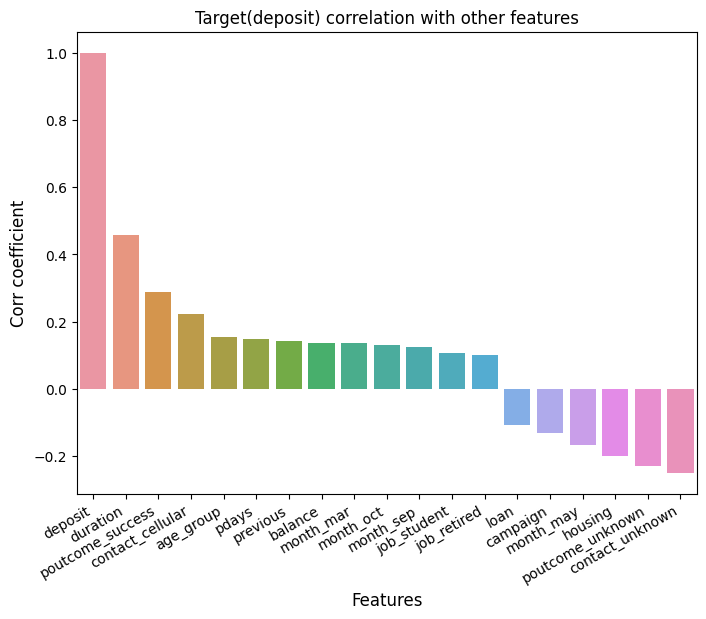

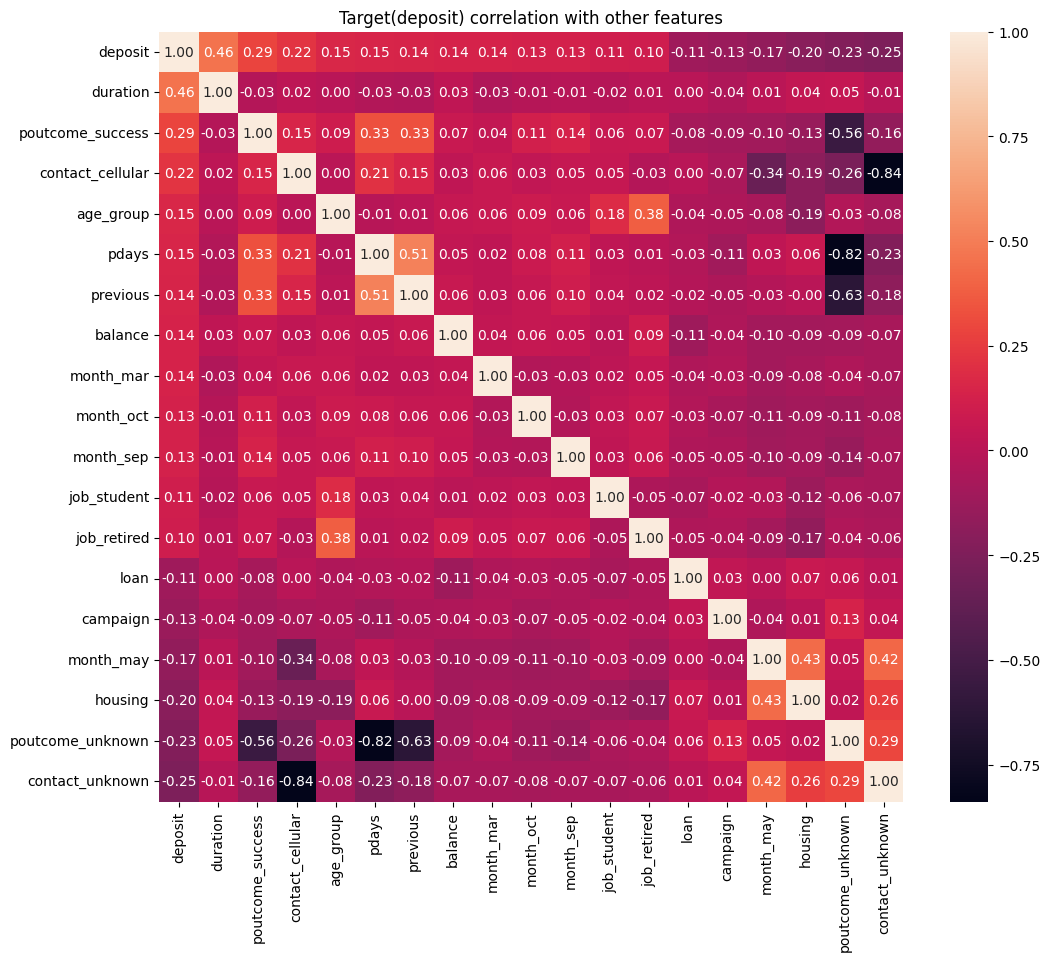

In [356]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
df_corr = dfc.corr()['deposit'].sort_values(ascending=False).reset_index()

plt.subplots(figsize=(8,6))
bp_corr = sns.barplot(df_corr[abs(df_corr['deposit'])>0.1], x='index', y='deposit');
bp_corr.set_title('Target(deposit) correlation with other features')
bp_corr.set_ylabel('Corr coefficient', fontsize=12)
bp_corr.set_xlabel('Features', fontsize=12);
#bp_corr.tick_params(axis='x', rotation=50)
plt.xticks(rotation=30, ha='right');
#sns.heatmap(dfc.corr(numeric_only=True), annot=True)

corr_fea = df_corr[abs(df_corr['deposit'])>0.1]['index'].tolist()
plt.subplots(figsize=(12,10))
sns.heatmap(dfc[corr_fea].corr(), annot=True, fmt='.2f').set_title('Target(deposit) correlation with other features');

In [357]:
X = dfc.drop(['deposit'], axis=1)
y = dfc['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

print(X_test.shape)

(3335, 45)


In [358]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
best_fea = selector.get_feature_names_out()
X_train = X_train[best_fea]
X_test = X_test[best_fea]
best_fea.tolist()

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [359]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
#scaler = preprocessing.RobustScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [360]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
#print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.81      3335



In [361]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    #criterion='gini', 
    criterion='entropy',
    random_state=42, #генератор случайных чисел
    #max_depth=6
)

dt.fit(X_train_scaled, y_train)

y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

TRAIN               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

TEST               precision    recall  f1-score   support

           0       0.77      0.77      0.77      1790
           1       0.74      0.73      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Max TEST accuracy 0.81 with max_depth 7
Max TEST f1       0.8 with max_depth 6


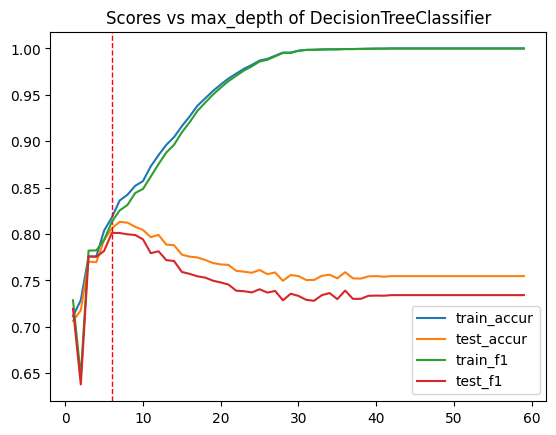

In [362]:
train = {'accuracy':[], 'f1':[]}
test = {'accuracy':[], 'f1':[]}
depths = np.arange(1,60,1)

for k in depths:
    dt = tree.DecisionTreeClassifier(
    #criterion='gini', 
    criterion='entropy',
    random_state=42, #генератор случайных чисел
    max_depth=k)

    dt.fit(X_train_scaled, y_train)

    y_pred_train = dt.predict(X_train_scaled)
    y_pred_test = dt.predict(X_test_scaled)

    train['accuracy'].append(metrics.accuracy_score(y_train, y_pred_train))
    train['f1'].append(metrics.f1_score(y_train, y_pred_train))
    test['accuracy'].append(metrics.accuracy_score(y_test, y_pred_test))
    test['f1'].append(metrics.f1_score(y_test, y_pred_test))

lp_te = sns.lineplot(x=depths, y=train['accuracy'], label='train_accur');
lp_tr = sns.lineplot(x=depths, y=test['accuracy'], label='test_accur');
lp_te.axvline(np.argmax(test['f1'])+1, color='r', lw=1, ls='--')
sns.lineplot(x=depths, y=train['f1'], label='train_f1');
sns.lineplot(x=depths, y=test['f1'], label='test_f1');
lp_te.set(title='Scores vs max_depth of DecisionTreeClassifier')

print(f"Max TEST accuracy {round(max(test['accuracy']),2)} with max_depth {np.argmax(test['accuracy'])+1}")
print(f"Max TEST f1       {round(max(test['f1']),2)} with max_depth {np.argmax(test['f1'])+1}")

In [363]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    #criterion='gini', 
    criterion='entropy',
    random_state=42, #генератор случайных чисел
    max_depth=6,
    #min_samples_split=2
)

dt.fit(X_train_scaled, y_train)

y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

TRAIN               precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.77      0.86      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

TEST               precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



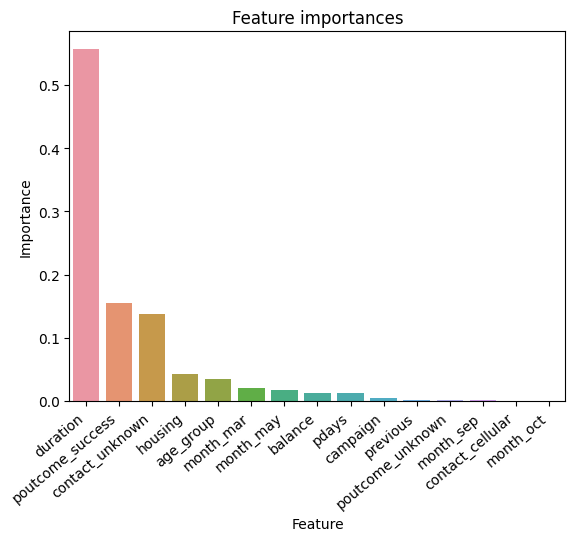

In [364]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fea_imp = pd.DataFrame({'feature':X_train.columns, 'importance':dt.feature_importances_}).sort_values(by='importance', ascending=False)
fea_imp.sort_values(by='importance', ascending=False)

bp_imp = sns.barplot(fea_imp, x='feature', y='importance')
bp_imp.set(xlabel='Feature', ylabel='Importance', title=f"Feature importances")
plt.xticks(rotation=40, ha='right');
#bp_imp.tick_params(axis='x',rotation=40, direction='out', pad=2, length=5, grid_alpha=0.3, which='both', color='red')

In [365]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
            'min_samples_split': [2, 5, 7, 10],
            'max_depth':[3,5,7],
            'min_samples_leaf': [2, 4, 6, 8, 10]}

gs = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42,
        criterion='entropy',
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time 
gs.fit(X_train_scaled, y_train) 

y_pred_train = gs.predict(X_train_scaled)
y_pred_test = gs.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")
print("Наилучшие значения гиперпараметров: {}".format(gs.best_params_))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs
TRAIN               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3634
           1       0.81      0.83      0.82      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770

TEST               precision    recall  f1-score   support

           0       0.83      0.82      0.83      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 2}


In [366]:
# обучите на ваших данных случайный лес
rf= ensemble.RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    max_depth=10, 
    min_samples_leaf=5, 
    random_state=42 
)
#Обучаем модель 
rf.fit(X_train_scaled, y_train)

y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")


TRAIN               precision    recall  f1-score   support

           0       0.87      0.86      0.87      3634
           1       0.84      0.85      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

TEST               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [367]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score_tr = metrics.f1_score(y_train, model.predict(X_train_scaled))
  score_te = metrics.f1_score(y_test, model.predict(X_test_scaled))
  #score = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring="f1", n_jobs=-1).mean()
  score = score_te / (score_tr - score_te)
  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2023-10-30 14:40:56,407] A new study created in memory with name: RandomForestClassifier
[I 2023-10-30 14:40:57,322] Trial 0 finished with value: 13.484432688509068 and parameters: {'n_estimators': 197, 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 0 with value: 13.484432688509068.
[I 2023-10-30 14:40:57,798] Trial 1 finished with value: 13.445844425596414 and parameters: {'n_estimators': 102, 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 0 with value: 13.484432688509068.
[I 2023-10-30 14:40:58,389] Trial 2 finished with value: 20.26717602289157 and parameters: {'n_estimators': 142, 'max_depth': 13, 'min_samples_leaf': 6}. Best is trial 2 with value: 20.26717602289157.
[I 2023-10-30 14:40:58,837] Trial 3 finished with value: 29.5938887618134 and parameters: {'n_estimators': 125, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 3 with value: 29.5938887618134.
[I 2023-10-30 14:40:59,352] Trial 4 finished with value: 21.144373829122156 and parameters: {'n_estim

Наилучшие значения гиперпараметров {'n_estimators': 113, 'max_depth': 10, 'min_samples_leaf': 9}
f1_score на обучающем наборе: 31.45


In [368]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")


TRAIN               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.85      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

TEST               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [369]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = 42
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

y_pred_train = gb.predict(X_train_scaled)
y_pred_test = gb.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

TRAIN               precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

TEST               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.83      0.83      3335



In [370]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  learning_rate = trial.suggest_float('learning_rate',0.01, 1)#, step=0.05)
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 1, 8, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8, 1)

  model = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                          learning_rate=learning_rate,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  #score_tr = metrics.f1_score(y_train, model.predict(X_train_scaled))
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))
  #score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  #score = score_te / (score_tr - score_te)
  return score

study = optuna.create_study(study_name="GBClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2023-10-30 14:41:10,753] A new study created in memory with name: GBClassifier
[I 2023-10-30 14:41:11,131] Trial 0 finished with value: 0.8031138501459617 and parameters: {'learning_rate': 0.9879634701978066, 'n_estimators': 105, 'max_depth': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8031138501459617.
[I 2023-10-30 14:41:12,716] Trial 1 finished with value: 0.7734700416533162 and parameters: {'learning_rate': 0.821040513783285, 'n_estimators': 137, 'max_depth': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8031138501459617.
[I 2023-10-30 14:41:13,747] Trial 2 finished with value: 0.7948717948717948 and parameters: {'learning_rate': 0.38836297869900127, 'n_estimators': 125, 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8031138501459617.
[I 2023-10-30 14:41:14,569] Trial 3 finished with value: 0.8039718129404227 and parameters: {'learning_rate': 0.5240855053210871, 'n_estimators': 152, 'max_depth': 3, 'min_samples_leaf': 4}. Best is tr

Наилучшие значения гиперпараметров {'learning_rate': 0.040189761676212694, 'n_estimators': 195, 'max_depth': 6, 'min_samples_leaf': 6}
f1_score на обучающем наборе: 0.82


In [371]:
model = ensemble.GradientBoostingClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

TRAIN               precision    recall  f1-score   support

           0       0.90      0.88      0.89      3634
           1       0.86      0.88      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770

TEST               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [373]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dr',tree.DecisionTreeClassifier(
        random_state=42,
        criterion='entropy',
        min_samples_split=2,
        min_samples_leaf=8,
        max_depth=7)),
    ('rf', ensemble.RandomForestClassifier(
        n_estimators=100, 
        criterion='gini', 
        max_depth=10, 
        min_samples_leaf=5, 
        random_state=42)),
    ('gb', GradientBoostingClassifier(
        learning_rate= 0.044446922102565754, 
        n_estimators= 148, 
        max_depth= 5, 
        min_samples_leaf= 3,
        random_state= 42))    
]

# Создаем объект класса стекинг
sc = StackingClassifier(
    estimators=estimators,
    #final_estimator=RandomForestRegressor(n_estimators=10, random_state=42)
    final_estimator=linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
)
# Обучаем модель
sc.fit(X_train_scaled, y_train)

y_pred_train = sc.predict(X_train_scaled)
y_pred_test = sc.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

TRAIN               precision    recall  f1-score   support

           0       0.88      0.87      0.87      3634
           1       0.85      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

TEST               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Best threshold = 0.33, F1-Score = 0.83


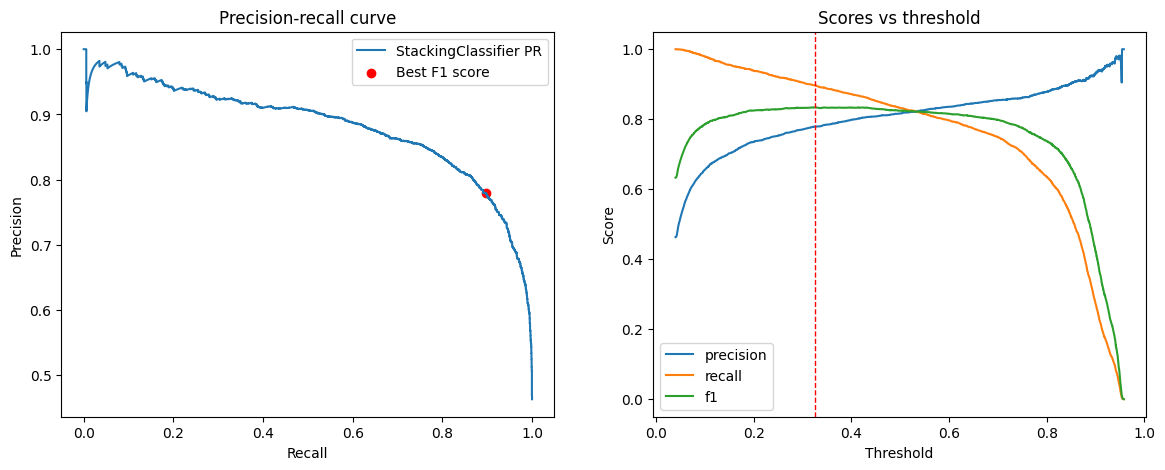

In [374]:
#skf = model_selection.StratifiedKFold(n_splits=5)

y_cv_proba_pred = model_selection.cross_val_predict(sc, X_train_scaled, y_train, cv=5, method='predict_proba')
y_cv_proba_pred = y_cv_proba_pred[:,1]

precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

f1_scores = (2 * precision * recall) / (precision + recall)
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))


fig, ax = plt.subplots(1,2,figsize=(14, 5)) 
ax[0].plot(recall, precision, label='StackingClassifier PR')
ax[0].scatter(recall[idx], precision[idx], marker='o', color='red', label='Best F1 score')
ax[1].plot(thresholds, precision[:-1], label='precision')
ax[1].plot(thresholds, recall[:-1], label='recall')
ax[1].plot(thresholds, f1_scores[:-1], label='f1')
ax[1].axvline(thresholds[idx], color='r', lw=1, ls='--')

ax[0].set_title('Precision-recall curve')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].legend()
ax[1].set_title('Scores vs threshold')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Score')
ax[1].legend();

In [375]:
threshold_opt = 0.33

y_test_pred_proba = sc.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')

print(f"TEST {metrics.classification_report(y_test, y_test_pred)}")

TEST               precision    recall  f1-score   support

           0       0.89      0.78      0.83      1790
           1       0.78      0.89      0.83      1545

    accuracy                           0.83      3335
   macro avg       0.84      0.84      0.83      3335
weighted avg       0.84      0.83      0.83      3335

